# Stock Price Prediction 

## Part I - Getting Data
**Open**: The opening price is the price at which a security first trades upon the opening of an exchange on a trading day

**Close**: The closing price is the last price at which the stock traded during the regular trading day

**High**: The high is the highest price 

**Low**: The low is the lowest price at which a stock traded during a period

**Adj Close**: Adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions, such as stock splits, dividends / distributions and rights offerings

**Volume**: Trading volume is a measure of how much of a given financial asset has traded in a period of time. For stocks, volume is measured in the number of shares traded and, for futures and options, it is based on how many contracts have changed hands

### Scraping Data From Yahoo Finance

In [1]:
import re
from io import StringIO
from datetime import datetime, timedelta

import requests
import pandas as pd


class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

In [2]:
df = YahooFinanceHistory('AAPL', days_back=365).get_quote()

In [9]:
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,170.160004,172.300003,169.259995,172.259995,166.353714,25555900
2018-01-03,172.529999,174.550003,171.960007,172.229996,166.324722,29517900
2018-01-04,172.539993,173.470001,172.080002,173.029999,167.097290,22434600
2018-01-05,173.440002,175.369995,173.050003,175.000000,168.999741,23660000
2018-01-08,174.350006,175.610001,173.929993,174.350006,168.372040,20567800


### Using Available Package 

In [5]:
import yfinance as yf
df = yf.download("AAPL", start="2018-01-01", end="2019-12-31")

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,170.160004,172.300003,169.259995,172.259995,166.353714,25555900
2018-01-03,172.529999,174.550003,171.960007,172.229996,166.324722,29517900
2018-01-04,172.539993,173.470001,172.080002,173.029999,167.097290,22434600
2018-01-05,173.440002,175.369995,173.050003,175.000000,168.999741,23660000
2018-01-08,174.350006,175.610001,173.929993,174.350006,168.372040,20567800


In [7]:
df.shape

(502, 6)

In [10]:
# convert index to date
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df['Date'] = pd.to_datetime(df.index,format='%Y-%m-%d')
df.index = df['Date']

## Part II - Visualisation

In [11]:
import pandas as pd
import matplotlib.pyplot as plt 


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Text(0, 0.5, 'Closing Price')

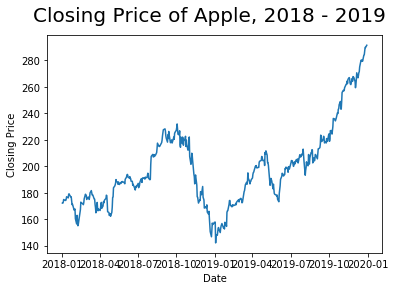

In [12]:
fig = plt.figure()
plt.plot(df['Close'])
fig.suptitle('Closing Price of Apple, 2018 - 2019', fontsize=20)
plt.xlabel("Date")
plt.ylabel("Closing Price")

## Part III - Prediction

### ARIMA

### Long Short Term Memory

In [15]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import numpy as np

In [16]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:400,:]
valid = dataset[400:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)

Train on 340 samples
340/340 - 17s - loss: 0.0061


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


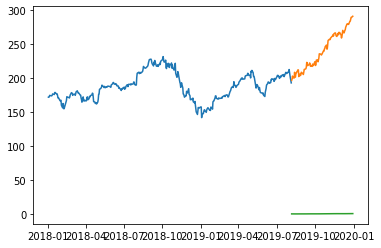

In [18]:
#for plotting
train = new_data[:400]
valid = new_data[400:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])